## IBM Capstone Project - II

In this notebook, we will use Chicago crime data to deermine which districts are safe for sentrepreneurs to open their restaurants.

Then we will use the foursquare API to explore the venues in the the favourable districts to see which type of businesses will be more favourable.

In [32]:
# import modules
import numpy as np
import pandas as pd
from pandas import *
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
from scipy import stats
sns.set_style("darkgrid")
import matplotlib.image as mpimg
from IPython.display import IFrame
import folium
from folium import plugins
import os
from folium.plugins import MarkerCluster, FastMarkerCluster, HeatMapWithTime

In [33]:
#Setting the Directory
os.chdir(r'G:\Github\Coursera_Capstone')

### Data Cleaning


This dataset reflects reported incidents of crime (with the exception of murders where data exists for each victim) that occurred in the City of Chicago from 2001 to present, minus the most recent seven days. Data is extracted from the Chicago Police Department's CLEAR (Citizen Law Enforcement Analysis and Reporting) system

In [6]:
# use TextFileReader iterable with chunks of 100,000 rows.
tp = read_csv('Crimes_-_2001_to_present.csv', iterator=True, chunksize=100000)  
crime_data = concat(tp, ignore_index=True)  

# print data's shape
crime_data.shape

(6910260, 30)

In [7]:
crime_data.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Longitude,Location,Historical Wards 2003-2015,Zip Codes,Community Areas,Census Tracts,Wards,Boundaries - ZIP Codes,Police Districts,Police Beats
0,11742890,JC330993,07/01/2019 11:50:00 PM,057XX S WENTWORTH AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,APARTMENT,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11742947,JC330997,07/01/2019 11:47:00 PM,062XX S ASHLAND AVE,1310,CRIMINAL DAMAGE,TO PROPERTY,RESTAURANT,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11746521,JC330996,07/01/2019 11:41:00 PM,078XX S WOLCOTT AVE,2826,OTHER OFFENSE,HARASSMENT BY ELECTRONIC MEANS,RESIDENCE,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11744797,JC333264,07/01/2019 11:30:00 PM,073XX S JEFFERY BLVD,031A,ROBBERY,ARMED: HANDGUN,SIDEWALK,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11743221,JC331314,07/01/2019 11:30:00 PM,002XX E 61ST ST,1320,CRIMINAL DAMAGE,TO VEHICLE,STREET,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6910260 entries, 0 to 6910259
Data columns (total 30 columns):
ID                            int64
Case Number                   object
Date                          object
Block                         object
IUCR                          object
Primary Type                  object
Description                   object
Location Description          object
Arrest                        bool
Domestic                      bool
Beat                          int64
District                      float64
Ward                          float64
Community Area                float64
FBI Code                      object
X Coordinate                  float64
Y Coordinate                  float64
Year                          int64
Updated On                    object
Latitude                      float64
Longitude                     float64
Location                      object
Historical Wards 2003-2015    float64
Zip Codes                     objec

#### Changing Date Column in to datetime.datetime object

In [10]:
# Changing the data column in to datetime.datetime objects

crime_data['Date'] = crime_data['Date'].apply(lambda x: datetime.datetime.strptime(x,"%m/%d/%Y %I:%M:%S %p"))
crime_data['Date'].dtypes

dtype('<M8[ns]')

#### Filtering the dataframe. Keeping only last five years data

In [11]:
# Since only last five years data is relevant to our problem
crime_data = crime_data.loc[(crime_data.Date.dt.year > 2014)]
crime_data.shape

(1193164, 30)

#### Saving the data in pickle so that it can be used on a low memory system

In [13]:
# save cleaned data to pickle file for easier loading from notebook start

crime_data.to_pickle('crime_data.pkl') 
print('pickle size:', os.stat('crime_data.pkl').st_size)

pickle size: 283949523


In [34]:
crime_filtered = pd.read_pickle('crime_data.pkl')
crime_filtered.shape

(1193164, 30)

#### Exploring the type of crimes in Chicago

In [6]:
crimes = crime_filtered['Primary Type'].sort_values().unique()
crimes, len(crimes)

(array(['ARSON', 'ASSAULT', 'BATTERY', 'BURGLARY',
        'CONCEALED CARRY LICENSE VIOLATION', 'CRIM SEXUAL ASSAULT',
        'CRIMINAL DAMAGE', 'CRIMINAL TRESPASS', 'DECEPTIVE PRACTICE',
        'GAMBLING', 'HOMICIDE', 'HUMAN TRAFFICKING',
        'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'KIDNAPPING',
        'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT', 'NARCOTICS',
        'NON - CRIMINAL', 'NON-CRIMINAL',
        'NON-CRIMINAL (SUBJECT SPECIFIED)', 'OBSCENITY',
        'OFFENSE INVOLVING CHILDREN', 'OTHER NARCOTIC VIOLATION',
        'OTHER OFFENSE', 'PROSTITUTION', 'PUBLIC INDECENCY',
        'PUBLIC PEACE VIOLATION', 'ROBBERY', 'SEX OFFENSE', 'STALKING',
        'THEFT', 'WEAPONS VIOLATION'], dtype=object), 33)

#### Crimes Affecting Open Restaurants

In [35]:
# create and preview dataframe containing crimes that may affect a restaurant business
#Ten crime types were selected out of thirty three types

colm = ['Date','Primary Type','Arrest','Domestic','District','Community Area',
            'Zip Codes','X Coordinate','Y Coordinate','Latitude','Longitude']
res_crimes = crime_filtered[colm]
res_crimes = res_crimes[res_crimes['Primary Type']\
                  .isin(['ASSAULT','PUBLIC INDECENCY','ROBBERY','INTIMIDATION','CRIMINAL TRESPASS','PUBLIC PEACE VIOLATION',
                         'CRIM SEXUAL ASSUALT','HOMICIDE','NARCOTICS','WEAPONS VIOLATION','NARCOTICS','PROSTITUTION','THEFT'])]

# clean some rouge (0,0) coordinates
#res_crimes = res_crimes[res_crimes['X Coordinate']!=0]

res_crimes.head()

,Date,Primary Type,Arrest,Domestic,District,Community Area,Zip Codes,X Coordinate,Y Coordinate,Latitude,Longitude
3,2019-07-01 23:30:00,ROBBERY,False,False,3.0,43.0,NaN,NaN,NaN,NaN,NaN
9,2019-07-01 23:26:00,NARCOTICS,True,False,4.0,51.0,NaN,NaN,NaN,NaN,NaN
11,2019-07-01 23:13:00,WEAPONS VIOLATION,True,False,4.0,51.0,NaN,NaN,NaN,NaN,NaN
16,2019-07-01 23:00:00,ROBBERY,True,False,14.0,22.0,NaN,NaN,NaN,NaN,NaN
19,2019-07-01 23:00:00,THEFT,False,False,7.0,67.0,NaN,NaN,NaN,NaN,NaN


#### Plot of restaurant affecting crimes in dataset by location per District


Text(0.5,1,'All Restaurant related Crimes per District')

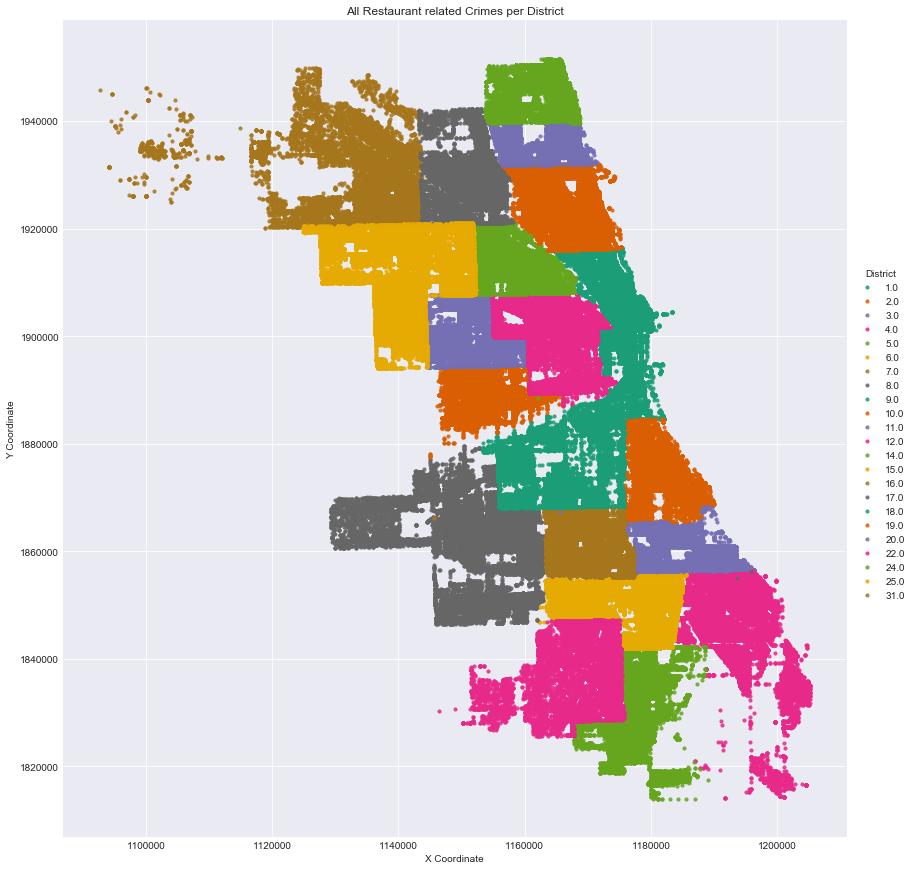

In [6]:

res_crime = res_crimes.loc[(res_crimes['X Coordinate']!=0)]

sns.lmplot('X Coordinate',
           'Y Coordinate',
           data=res_crime[:],
           fit_reg=False, 
           hue="District", 
           palette='Dark2',
           size=12,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10}) 
ax = plt.gca()
ax.set_title("All Restaurant related Crimes per District")

#### Visualizing each geo distribution scatter plot for each of the crimes in the group 

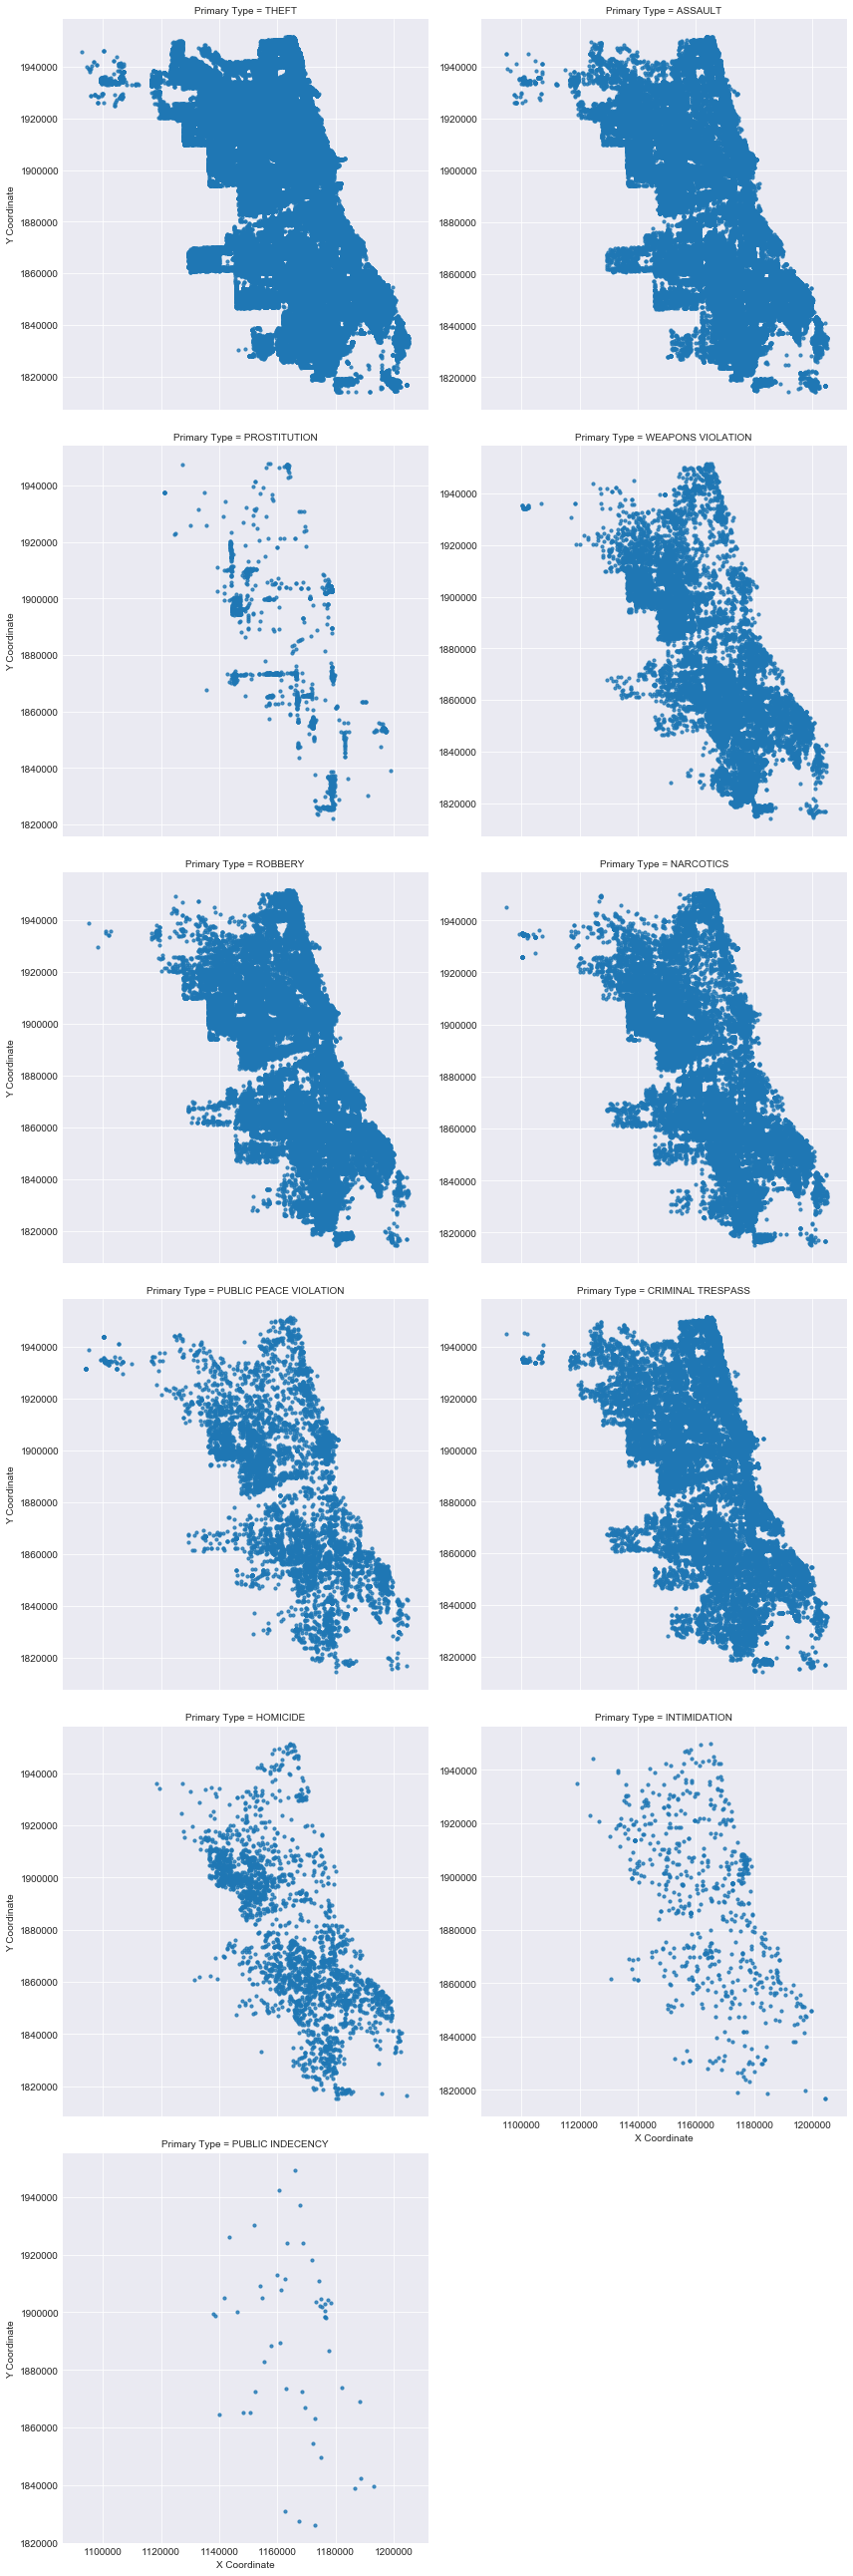

In [7]:
res_crime = res_crimes
g = sns.lmplot(x="X Coordinate",
               y="Y Coordinate",
               col="Primary Type",
               data= res_crime.dropna(), 
               col_wrap=2, size=6, fit_reg=False, 
               sharey=False,
               scatter_kws={"marker": "D",
                            "s": 10})

### One-hot Encoding for Clustering

In [36]:
# one hot encoding
cr_onehot = pd.get_dummies(res_crimes[['Primary Type']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cr_onehot['District'] = res_crimes['District'] 

# move neighborhood column to the first column
fixed_columns = [cr_onehot.columns[-1]] + list(cr_onehot.columns[:-1])
cr_onehot = cr_onehot[fixed_columns]

cr_onehot.head()

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION
3,3.0,0,0,0,0,0,0,0,0,1,0,0
9,4.0,0,0,0,0,1,0,0,0,0,0,0
11,4.0,0,0,0,0,0,0,0,0,0,0,1
16,14.0,0,0,0,0,0,0,0,0,1,0,0
19,7.0,0,0,0,0,0,0,0,0,0,1,0


In [37]:
cr = cr_onehot['District'].sort_values().unique()
cr, len(cr)

(array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 14.,
        15., 16., 17., 18., 19., 20., 22., 24., 25., 31.]), 23)

In [38]:
cr_grouped = cr_onehot.groupby('District').mean().reset_index()
cr_grouped.head()

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION
0,1.0,0.077350,0.058369,0.000725,0.000925,0.019031,0.001500,0.000175,0.009578,0.049791,0.778778,0.003776
1,2.0,0.183064,0.053856,0.005543,0.001487,0.067646,0.002884,0.000090,0.010636,0.112759,0.534544,0.027491
2,3.0,0.228812,0.061919,0.007752,0.001634,0.098155,0.000794,0.000000,0.016530,0.127761,0.406864,0.049778
3,4.0,0.237039,0.061397,0.006664,0.001040,0.122833,0.002196,0.000077,0.018566,0.091672,0.400008,0.058509
4,5.0,0.230083,0.064984,0.009455,0.001200,0.120033,0.013198,0.000096,0.016078,0.085621,0.380255,0.078998


In [39]:
cr_loc = res_crimes[['District','Latitude','Longitude']]
cr_loc = cr_loc.groupby('District').mean().reset_index()
cr_loc.head()

,District,Latitude,Longitude
0,1.0,41.875991,-87.628990
1,2.0,41.810199,-87.611016
2,3.0,41.771165,-87.596597
3,4.0,41.734852,-87.564789
4,5.0,41.688553,-87.621366


In [40]:
cr_d = res_crimes[['District', 'Community Area', 'Zip Codes']]
cr_d = cr_d.groupby('Community Area')
cr_d.head(5)

,District,Community Area,Zip Codes
3,3.0,43.0,NaN
9,4.0,51.0,NaN
11,4.0,51.0,NaN
16,14.0,22.0,NaN
19,7.0,67.0,NaN
21,18.0,8.0,NaN
22,11.0,25.0,NaN
23,6.0,44.0,NaN
24,4.0,48.0,NaN
25,14.0,22.0,NaN


In [41]:
cr_m = pd.merge(cr_grouped, cr_loc, on ='District')
cr_m.head()

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION,Latitude,Longitude
0,1.0,0.077350,0.058369,0.000725,0.000925,0.019031,0.001500,0.000175,0.009578,0.049791,0.778778,0.003776,41.875991,-87.628990
1,2.0,0.183064,0.053856,0.005543,0.001487,0.067646,0.002884,0.000090,0.010636,0.112759,0.534544,0.027491,41.810199,-87.611016
2,3.0,0.228812,0.061919,0.007752,0.001634,0.098155,0.000794,0.000000,0.016530,0.127761,0.406864,0.049778,41.771165,-87.596597
3,4.0,0.237039,0.061397,0.006664,0.001040,0.122833,0.002196,0.000077,0.018566,0.091672,0.400008,0.058509,41.734852,-87.564789
4,5.0,0.230083,0.064984,0.009455,0.001200,0.120033,0.013198,0.000096,0.016078,0.085621,0.380255,0.078998,41.688553,-87.621366


### K-Means Clustering

In [42]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 2

cr_clustering = cr_grouped.drop('District', 1)


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cr_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       1])

In [43]:
cr_merged = cr_m

# add clustering labels
cr_merged['Cluster Labels'] = kmeans.labels_

cr_merged.head()

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION,Latitude,Longitude,Cluster Labels
0,1.0,0.077350,0.058369,0.000725,0.000925,0.019031,0.001500,0.000175,0.009578,0.049791,0.778778,0.003776,41.875991,-87.628990,1
1,2.0,0.183064,0.053856,0.005543,0.001487,0.067646,0.002884,0.000090,0.010636,0.112759,0.534544,0.027491,41.810199,-87.611016,1
2,3.0,0.228812,0.061919,0.007752,0.001634,0.098155,0.000794,0.000000,0.016530,0.127761,0.406864,0.049778,41.771165,-87.596597,0
3,4.0,0.237039,0.061397,0.006664,0.001040,0.122833,0.002196,0.000077,0.018566,0.091672,0.400008,0.058509,41.734852,-87.564789,0
4,5.0,0.230083,0.064984,0.009455,0.001200,0.120033,0.013198,0.000096,0.016078,0.085621,0.380255,0.078998,41.688553,-87.621366,0


#### Plotting Clusters

In [44]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude_chi = 41.881832
longitude_chi = -87.623177
# create map
map_clusters = folium.Map(location = [latitude_chi, longitude_chi], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cr_merged['Latitude'], cr_merged['Longitude'], cr_merged['District'], cr_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Cluster 1 is colored as "Purple" and Cluster 2 is colored as "Red"

In [45]:
new = cr_merged.set_index(['Cluster Labels'])
new = new.sort_index()
new

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION,Latitude,Longitude
Cluster Labels,,,,,,,,,,,,,,
0,3.0,0.228812,0.061919,0.007752,0.001634,0.098155,0.000794,0.000000,0.016530,0.127761,0.406864,0.049778,41.771165,-87.596597
0,4.0,0.237039,0.061397,0.006664,0.001040,0.122833,0.002196,0.000077,0.018566,0.091672,0.400008,0.058509,41.734852,-87.564789
0,5.0,0.230083,0.064984,0.009455,0.001200,0.120033,0.013198,0.000096,0.016078,0.085621,0.380255,0.078998,41.688553,-87.621366
0,6.0,0.203854,0.061349,0.007024,0.000506,0.118332,0.002689,0.000063,0.015060,0.105391,0.425520,0.060210,41.745501,-87.632139
0,7.0,0.210736,0.053163,0.009505,0.000847,0.198062,0.015953,0.000074,0.018310,0.096121,0.311683,0.085547,41.775580,-87.653667
0,8.0,0.182646,0.048679,0.006253,0.001647,0.099980,0.007396,0.000134,0.015901,0.100988,0.502521,0.033853,41.778048,-87.715701
0,9.0,0.188900,0.048740,0.008299,0.002327,0.130939,0.006982,0.000088,0.013129,0.106349,0.444981,0.049267,41.816583,-87.664129
0,10.0,0.172334,0.049452,0.007036,0.001415,0.262262,0.000809,0.000081,0.023776,0.098500,0.318467,0.065869,41.854399,-87.712681
0,11.0,0.132952,0.039345,0.007226,0.000687,0.420402,0.043667,0.000044,0.018088,0.091812,0.198386,0.047391,41.881414,-87.720539


### Analysis
#### Cluster 0 (Red):
For the districts in cluster 0, the crime rate is high. We can see the mean values for Asssault, Narcotics, Prostitution, Robbery, and Weapons Violations are considerably high for districts in Cluster 0. Thus, as per crime data, entrepreneurs should avoid the districts in Cluster 0.

#### Cluster 1 (Purple): 
For the districts in Cluster 1, the crimes rates are relatively very low. These districts are very good choice for opening a restaurant as the negatie externalities are reduced.

In [46]:
sel_dist = cr_merged.loc[(cr_merged['Cluster Labels']!=0)]
sel_dist

,District,ASSAULT,CRIMINAL TRESPASS,HOMICIDE,INTIMIDATION,NARCOTICS,PROSTITUTION,PUBLIC INDECENCY,PUBLIC PEACE VIOLATION,ROBBERY,THEFT,WEAPONS VIOLATION,Latitude,Longitude,Cluster Labels
0,1.0,0.077350,0.058369,0.000725,0.000925,0.019031,0.001500,0.000175,0.009578,0.049791,0.778778,0.003776,41.875991,-87.628990,1
1,2.0,0.183064,0.053856,0.005543,0.001487,0.067646,0.002884,0.000090,0.010636,0.112759,0.534544,0.027491,41.810199,-87.611016,1
11,12.0,0.131324,0.045064,0.003281,0.001554,0.055596,0.001727,0.000069,0.009738,0.083808,0.651576,0.016264,41.881829,-87.669616,1
12,14.0,0.110508,0.045390,0.001931,0.000598,0.030766,0.000414,0.000138,0.008232,0.077443,0.709772,0.014808,41.916728,-87.689720,1
14,16.0,0.163081,0.095161,0.000904,0.001567,0.082806,0.000844,0.000060,0.016151,0.038691,0.587959,0.012776,41.967084,-87.805514,1
15,17.0,0.134906,0.045176,0.002828,0.001862,0.048900,0.000966,0.000069,0.008414,0.086351,0.652942,0.017587,41.961146,-87.721251,1
16,18.0,0.064244,0.047370,0.000560,0.001013,0.021912,0.002159,0.000160,0.007971,0.050036,0.799403,0.005172,41.901674,-87.633783,1
17,19.0,0.091163,0.064329,0.001140,0.001287,0.033120,0.000404,0.000110,0.010918,0.066865,0.723938,0.006727,41.946310,-87.658716,1
18,20.0,0.146494,0.073247,0.001563,0.001787,0.055940,0.000447,0.000112,0.011501,0.060295,0.633988,0.014627,41.978298,-87.671465,1
20,24.0,0.151320,0.075660,0.002918,0.001154,0.057067,0.002171,0.000136,0.009907,0.082378,0.598901,0.018389,42.006471,-87.677598,1


In [47]:
res = res_crimes
#res = res_crimes.dropna(axis = 0)
#res = res.dropna(subset = ['District'])
res = res.drop(['Date', 'Primary Type','Arrest', 'Domestic','X Coordinate', 'Y Coordinate'],axis = 1)
res.head()

,District,Community Area,Zip Codes,Latitude,Longitude
3,3.0,43.0,NaN,NaN,NaN
9,4.0,51.0,NaN,NaN,NaN
11,4.0,51.0,NaN,NaN,NaN
16,14.0,22.0,NaN,NaN,NaN
19,7.0,67.0,NaN,NaN,NaN


In [48]:
com = res[['Community Area', 'Latitude', 'Longitude']]
com = com.groupby('Community Area').mean().reset_index()
com.head()

,Community Area,Latitude,Longitude
0,0.0,42.006074,-87.927365
1,1.0,42.012315,-87.670509
2,2.0,41.999993,-87.692820
3,3.0,41.966083,-87.656701
4,4.0,41.971788,-87.687843


In [49]:
res.drop(['Latitude', 'Longitude'], axis =1, inplace = True)
testt = pd.merge(res,com, on = 'Community Area')
testt.head()

,District,Community Area,Zip Codes,Latitude,Longitude
0,3.0,43.0,NaN,41.761767,-87.573882
1,4.0,43.0,NaN,41.761767,-87.573882
2,4.0,43.0,NaN,41.761767,-87.573882
3,3.0,43.0,NaN,41.761767,-87.573882
4,4.0,43.0,NaN,41.761767,-87.573882


In [50]:
sel = cr_merged[['District', 'Cluster Labels']]
sel.head()

,District,Cluster Labels
0,1.0,1
1,2.0,1
2,3.0,0
3,4.0,0
4,5.0,0


In [51]:
#This dataframe contains districts and community areas from cluster 1 - the good one
#newres.drop(['Latitude', 'Longitude'], axis =1, inplace = True)
newres = pd.merge(sel, testt, on = 'District')
newres = newres.loc[(newres['Cluster Labels']!=0)]
newres.head()

,District,Cluster Labels,Community Area,Zip Codes,Latitude,Longitude
0,1.0,1,32.0,NaN,41.880831,-87.627799
1,1.0,1,32.0,NaN,41.880831,-87.627799
2,1.0,1,32.0,NaN,41.880831,-87.627799
3,1.0,1,32.0,NaN,41.880831,-87.627799
4,1.0,1,32.0,NaN,41.880831,-87.627799


## Venues in the Districts in Cluster 1

So now we have only those districts for which the crime rate is low. Let's explore restaurants in these districts only. We fill use the Foursquare library for this.

In [52]:
from bs4 import BeautifulSoup as bsoup
from urllib.request import urlopen as uReq
import requests
import lxml

In [55]:
CLIENT_ID = 'PMMJI0MO00LSRLBQOT4D3PORFMTICOIKWELYB0ZHELLIDH0L' # your Foursquare ID
CLIENT_SECRET = 'W3A3LSCXZLVBVFJWY3TTJJYN4PHQGDMOFW3MT4HYUF3CFOTV' # your Foursquare Secret
VERSION = '20180604'
radius = 500
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PMMJI0MO00LSRLBQOT4D3PORFMTICOIKWELYB0ZHELLIDH0L
CLIENT_SECRET:W3A3LSCXZLVBVFJWY3TTJJYN4PHQGDMOFW3MT4HYUF3CFOTV


#### Geographical coordinates for Chicago

In [54]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Chicago, IL'

geolocator = Nominatim(user_agent="Jupyter")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Chicago are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Chicago are 41.8755616, -87.6244212.


#### Requesting data for top 100 venues in Chicago

In [56]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d355d7bf19f4400252a261d'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'South Loop',
  'headerFullLocation': 'South Loop, Chicago',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 112,
  'suggestedBounds': {'ne': {'lat': 41.8800616045, 'lng': -87.61838893486689},
   'sw': {'lat': 41.871061595499995, 'lng': -87.63045346513312}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ae786a5f964a52019ac21e3',
       'name': 'Auditorium Theatre',
       'location': {'address': '50 E Congress Pkwy',
        'crossStreet': 'Roosevelt University',
        'lat': 41.87605807115569,
        'lng': -

In [28]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [29]:
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

venues = results['response']['groups'][0]['items']  
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,postalCode
0,Auditorium Theatre,Theater,41.876058,-87.625303,60605
1,Cafecito,Cuban Restaurant,41.875724,-87.626386,60605
2,Osaka Sushi Express & Fresh Fruit Smoothies,Sushi Restaurant,41.876969,-87.624534,60605
3,Hostelling International Chicago,Hostel,41.875757,-87.626537,60605
4,SummerDance,Dance Studio,41.873804,-87.623335,60605


In [30]:
newres.rename(columns={'Zip Codes':'postalCode'}, inplace=True)
newres.head()

,District,Cluster Labels,Community Area,postalCode,Latitude,Longitude
0,1.0,1,32.0,NaN,41.880831,-87.627799
1,1.0,1,32.0,NaN,41.880831,-87.627799
2,1.0,1,32.0,NaN,41.880831,-87.627799
3,1.0,1,32.0,NaN,41.880831,-87.627799
4,1.0,1,32.0,NaN,41.880831,-87.627799


In [31]:
huhu = pd.merge(nearby_venues, newres, on = 'postalCode')
huhu.head()

,name,categories,lat,lng,postalCode,District,Cluster Labels,Community Area,Latitude,Longitude
0,Museum Shop,Arts & Crafts Store,41.879513,-87.623911,NaN,1.0,1,32.0,41.880831,-87.627799
1,Museum Shop,Arts & Crafts Store,41.879513,-87.623911,NaN,1.0,1,32.0,41.880831,-87.627799
2,Museum Shop,Arts & Crafts Store,41.879513,-87.623911,NaN,1.0,1,32.0,41.880831,-87.627799
3,Museum Shop,Arts & Crafts Store,41.879513,-87.623911,NaN,1.0,1,32.0,41.880831,-87.627799
4,Museum Shop,Arts & Crafts Store,41.879513,-87.623911,NaN,1.0,1,32.0,41.880831,-87.627799


Thus, we have a dataframe which tells us the venues present in the favourable districts. By studying the present venues and their location on the map, we can do an insighful customer analysis. This will tell us more about the type of restaurant that should be open in an area.

#### Visualization venues of interest in the favourable districts

In [ ]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
latitude_chi = 41.881832
longitude_chi = -87.623177
# create map
map_clusters = folium.Map(location = [latitude_chi, longitude_chi], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(huhu['Latitude'], huhu['Longitude'], huhu['District'], huhu['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters